In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import dates
from matplotlib.pyplot import figure
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\vbatch2\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
crypto_prices_df = pd.read_csv('chasewillden-cryptocurrency-price-by-date-2013-february-2018/chasewillden-cryptocurrency-price-by-date-2013-february-2018/data/cryptocurrency_prices_by_date.csv')

# Extract prices for the timeframe 01/01/2015 - 12/31/2018
# 2015-01-01 00:00:00  => 1420070400000
# 2018-12-31 23:59:59 => 1546261199000
crypto_prices_df = crypto_prices_df[(crypto_prices_df['date'] >= 1420070400000) & (crypto_prices_df['date'] <= 1546261199000)]

#print(crypto_prices_df.keys())

# Convert Unix time to Date time
crypto_prices_df['date'] = pd.to_datetime(crypto_prices_df['date'], unit='ms')
## prices.drop_duplicates('currency', keep='last')
## print(prices['currency'].unique())
crypto_prices_df['Year'] = crypto_prices_df['date'].dt.year
crypto_prices_df['Month'] = crypto_prices_df['date'].dt.month
crypto_prices_df['Day'] = crypto_prices_df['date'].dt.day
crypto_prices_df['YearMonth'] = crypto_prices_df['date'].dt.to_period('m')
crypto_prices_df[(crypto_prices_df['currency'] == 'bitcoin')].head(20)

,currency,date,price,Year,Month,Day,YearMonth
64769,bitcoin,2015-01-01 02:40:00,317.848,2015,1,1,2015-01
64770,bitcoin,2015-01-02 00:53:20,313.639,2015,1,2,2015-01
64771,bitcoin,2015-01-03 01:53:20,314.870,2015,1,3,2015-01
64772,bitcoin,2015-01-04 00:06:40,281.246,2015,1,4,2015-01
64773,bitcoin,2015-01-05 01:06:40,266.723,2015,1,5,2015-01
64774,bitcoin,2015-01-06 02:06:40,274.168,2015,1,6,2015-01
64775,bitcoin,2015-01-07 00:20:00,283.238,2015,1,7,2015-01
64776,bitcoin,2015-01-08 01:20:00,293.754,2015,1,8,2015-01
64777,bitcoin,2015-01-09 02:20:00,282.507,2015,1,9,2015-01
64778,bitcoin,2015-01-10 08:53:20,277.861,2015,1,10,2015-01


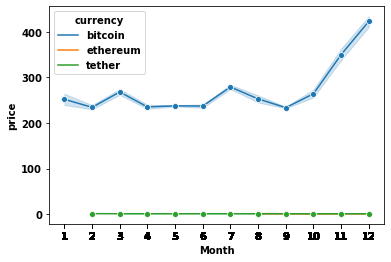

In [4]:
popular_cryptos2 = ['bitcoin','ethereum', 'tether', 'binance-coin', 'cardano']
prices_of_popular_cryptos2 = crypto_prices_df[crypto_prices_df['currency'].isin(popular_cryptos2)]
price_2015 = prices_of_popular_cryptos2[(prices_of_popular_cryptos2['Year']==2015)]
ax = sns.lineplot(data=price_2015, x='Month', y='price', hue='currency',marker='o')
ax.set(xticks=prices_of_popular_cryptos2.Month.values)
plt.show()



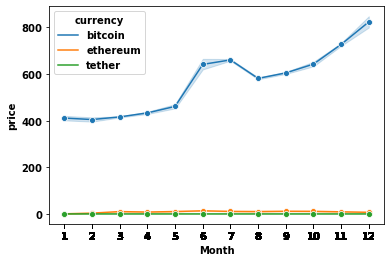

In [5]:

price_2016 = prices_of_popular_cryptos2[(prices_of_popular_cryptos2['Year']==2016)]
ax = sns.lineplot(data=price_2016, x='Month', y='price', hue='currency',marker='o')
ax.set(xticks=prices_of_popular_cryptos2.Month.values)
plt.show()

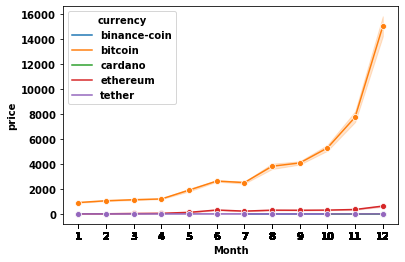

In [6]:

price_2017 = prices_of_popular_cryptos2[(prices_of_popular_cryptos2['Year']==2017)]
ax = sns.lineplot(data=price_2017, x='Month', y='price', hue='currency',marker='o')
ax.set(xticks=prices_of_popular_cryptos2.Month.values)
plt.show()

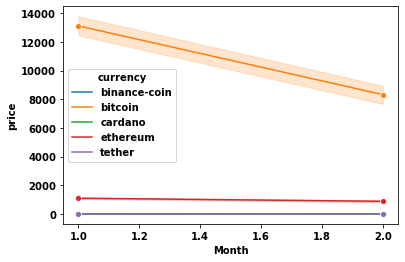

In [7]:
price_2018 = prices_of_popular_cryptos2[(prices_of_popular_cryptos2['Year']==2018)]
ax = sns.lineplot(data=price_2018, x='Month', y='price', hue='currency',marker='o')
plt.show()

In [8]:
popular_cryptos = ['bitcoin','ethereum', 'tether', 'binance-coin', 'litecoin', 'dogecoin', 'cardano', 'monero', 'ripple']

prices_of_popular_cryptos = crypto_prices_df[crypto_prices_df['currency'].isin(popular_cryptos)]

prices_of_popular_cryptos.drop_duplicates('currency', keep='last')


,currency,date,price,Year,Month,Day,YearMonth
51064,binance-coin,2018-02-10 02:33:20,10.238900,2018,2,10,2018-02
65899,bitcoin,2018-02-10 02:33:20,9037.510000,2018,2,10,2018-02
119853,cardano,2018-02-10 02:33:20,0.457995,2018,2,10,2018-02
188877,dogecoin,2018-02-10 02:33:20,0.005225,2018,2,10,2018-02
220978,ethereum,2018-02-10 02:33:20,904.994000,2018,2,10,2018-02
353462,litecoin,2018-02-10 02:33:20,167.287000,2018,2,10,2018-02
385124,monero,2018-02-10 02:33:20,267.645000,2018,2,10,2018-02
499855,ripple,2018-02-10 02:33:20,1.061200,2018,2,10,2018-02
578575,tether,2018-02-10 02:33:20,1.005510,2018,2,10,2018-02


In [9]:
# ax = sns.lineplot(data=crypto_prices_df[crypto_prices_df['currency'] == 'bitcoin'], x="date", y="price")

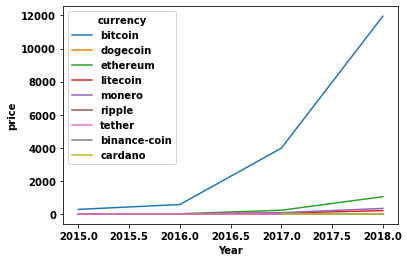

In [10]:
monthly_avg_prices = crypto_prices_df[crypto_prices_df['currency'].isin(popular_cryptos)].groupby(
    ["Year","currency"],as_index=True).mean().reset_index()
monthly_avg_prices

ax = sns.lineplot(data=monthly_avg_prices, x='Year', y='price',hue='currency')
# ax.set_yscale("log")
# ax = sns.lineplot(data=monthly_avg_prices[monthly_avg_prices['currency']=='bitcoin'], x='YearMonth', y='price',hue='currency')
# ax.set_xticks(ax.get_xticks().tolist())
# ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
# ax.set_xticklabels([pd.to_datetime(dateTime, unit='s').strftime('%Y-%m-%d\n %H:%M:%S') for dateTime in xticks],rotation=30)
# print(ax.get_xticks())


In [11]:
news = pd.read_json('cryptodata/news.json')
reddit = pd.read_json('cryptodata/reddit.json')
bitcoinTalk = pd.read_json('cryptodata/bitcointalk.json')

In [15]:
news = news[(news['date'].dt.year >= 2015) & (news['date'].dt.year <= 2018)]
reddit = reddit[(reddit['date'].dt.year >= 2015) & (reddit['date'].dt.year <= 2018)]
bitcoinTalk = bitcoinTalk[(bitcoinTalk['date'].dt.year >= 2015) & (bitcoinTalk['date'].dt.year <= 2018)]

print(len(news))
print(len(reddit))
print(len(bitcoinTalk))

#reddit.head(5)
#bitcoinTalk.head(5)
news.head(5)

63252


,text,post_id,date
9698,Venture capitalist Lou Kerner says bitcoin is ...,9783,2018-12-31 23:37:58
9699,"Charlie Lee, the creator of Litecoin and the m...",9784,2018-12-31 23:30:27
9700,As crypto’s value has dropped across the board...,9785,2018-12-31 23:24:38
9701,Hacks and heists have been a threat for as lon...,9786,2018-12-31 23:05:03
9702,It’s been over a year ...,9787,2018-12-31 22:46:45


In [18]:
news['year'] = news['date'].dt.year
news['month'] = news['date'].dt.month
reddit['year'] = reddit['date'].dt.year
reddit['month'] = reddit['date'].dt.month
bitcoinTalk['year'] = bitcoinTalk['date'].dt.year
bitcoinTalk['month'] = bitcoinTalk['date'].dt.month

In [19]:
news.head()

,text,post_id,date,year,month
9698,Venture capitalist Lou Kerner says bitcoin is ...,9783,2018-12-31 23:37:58,2018,12
9699,"Charlie Lee, the creator of Litecoin and the m...",9784,2018-12-31 23:30:27,2018,12
9700,As crypto’s value has dropped across the board...,9785,2018-12-31 23:24:38,2018,12
9701,Hacks and heists have been a threat for as lon...,9786,2018-12-31 23:05:03,2018,12
9702,It’s been over a year ...,9787,2018-12-31 22:46:45,2018,12


In [21]:
news_per_year = news.groupby(['year']).size().to_frame('size').reset_index()
news_per_month = news.groupby(['year','month']).size().to_frame('size').reset_index()
reddit_per_year = reddit.groupby(['year']).size().to_frame('size').reset_index()
reddit_per_month = reddit.groupby(['year','month']).size().to_frame('size').reset_index()
bitcoinTalk_per_year = bitcoinTalk.groupby(['year']).size().to_frame('size').reset_index()
bitcoinTalk_per_month = bitcoinTalk.groupby(['year','month']).size().to_frame('size').reset_index()



In [22]:
news_per_year.head()
# news_per_month.head(15)
# reddit_per_year.head()
# reddit_per_month.head(15)
# bitcoinTalk_per_year.head()
# bitcoinTalk_per_month.head(15)

,year,size
0,2016,1
1,2017,8366
2,2018,54885


In [23]:
news_per_year.loc[-1] = [2015,0]
news_per_year.index = news_per_year.index + 1  # shifting index
news_per_year.sort_index(inplace=True) 
print(news_per_year)

   year   size
0  2015      0
1  2016      1
2  2017   8366
3  2018  54885


In [25]:
fig,ax = plt.subplots()
index = np.arange(max(len(reddit_per_year['year']), len(news_per_year['year']), len(bitcoinTalk_per_year['year'])))
bar_width = 0.2
opacity = 0.8


ax.bar(index-bar_width, news_per_year['size'], color='r', width=bar_width, label='News')
ax.bar(index, reddit_per_year['size'], color='g', width=bar_width, label='Reddit')
ax.bar(index+bar_width, bitcoinTalk_per_year['size'], color='b', width=bar_width, label='Bitcoin Talk')

ax.set_yscale('log')
ax.tick_params(axis=u'both', which=u'both',length=0)
labels = ['','2015','','2016','','2017','','2018','']
ax.set_xticklabels(labels)

plt.xlabel('Year')
plt.ylabel('Amount of content (log scale)')
plt.title('Amount of content regarding cryptocurrency from 2015-2017')
plt.legend(loc='best')

plt.show()

In [34]:
fig,ax = plt.subplots()
index = np.arange(max(len(reddit_per_month['year']), len(news_per_month['year']), len(bitcoinTalk_per_month['year'])))
bar_width = 0.25
opacity = 0.8

# ax.bar(index-bar_width, news_per_month['size'], color='r', width=bar_width, label='Reddit')
ax.bar(index, reddit_per_month['size'], color='r', width=bar_width, label='Reddit')
ax.bar(index+bar_width, bitcoinTalk_per_month['size'], color='b', width=bar_width, label='Bitcoin Talk')

# ax.set_xticklabels(reddit_per_year['year'])

plt.show()

In [27]:
#sentiment analysis using vader
sid = SentimentIntensityAnalyzer()
news['scores'] = news['text'].apply(lambda text: sid.polarity_scores(text))
news['compound']  = news['scores'].apply(lambda score_dict: score_dict['compound'])
news['comp_score'] = news['compound'].apply(lambda c: 1 if c >=0 else -1)
news = news.drop(['scores', 'compound'], axis = 1)
news["Date_extracted"] = news["date"].dt.date
def text_extracting(data):
    data = word_tokenize(data)
    for i in range(len(data)):
        if data[i] == 'bitcoin':
            return 'bitcoin'
        elif data[i] == 'ethereum':
            return 'ethereum'
        elif data[i] == 'tether':
            return 'tether'
        elif data[i] == 'binance-coin':
            return 'binance-coin'
        elif data[i] == 'cardano':
            return 'cardano'
    return 'rest'
news['crypto'] = news['text'].apply(text_extracting)
news = news.sort_values('Date_extracted')
news['Year'] = news['date'].dt.year
news['Month'] = news['date'].dt.month
news['Day'] = news['date'].dt.day
news.head()


,text,post_id,date,year,month,comp_score,Date_extracted,crypto,Year,Month,Day
78901,SuperNET Weekly No. 13CORE and CORE Media were...,79011,2016-06-04,2016,6,1,2016-06-04,rest,2016,6,4
38830,This week we have several updates about Waves ...,38915,2017-02-13,2017,2,1,2017-02-13,bitcoin,2017,2,13
78900,WAVES Weekly No. 30This week we have several u...,79010,2017-02-13,2017,2,1,2017-02-13,bitcoin,2017,2,13
78899,WAVES Weekly No. 31Last week has seen a number...,79009,2017-02-20,2017,2,1,2017-02-20,bitcoin,2017,2,20
38829,Last week has seen a number of updates that sh...,38914,2017-02-20,2017,2,1,2017-02-20,bitcoin,2017,2,20


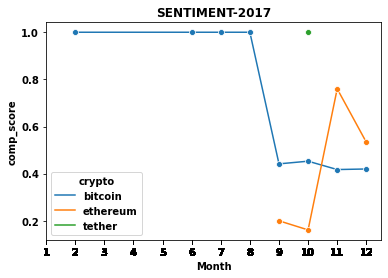

In [28]:
popular_cryptos2 = ['bitcoin','ethereum', 'tether']
news_of_popular_cryptos2 = news[news['crypto'].isin(popular_cryptos2)]
news_2017 = news_of_popular_cryptos2[(news_of_popular_cryptos2['Year']==2017)]
ax = sns.lineplot(data=news_2017, x='Month', y='comp_score', hue='crypto',marker='o',ci= None)
ax.set(xticks=news_of_popular_cryptos2.Month.values)
plt.title('SENTIMENT-2017')
plt.show()

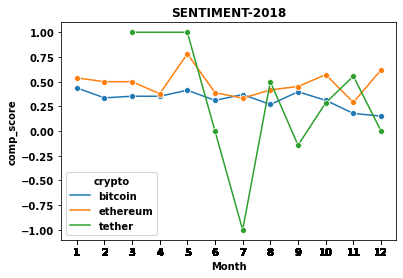

In [29]:
news_2018 = news_of_popular_cryptos2[(news_of_popular_cryptos2['Year']==2018)]
ax = sns.lineplot(data=news_2018, x='Month', y='comp_score', hue='crypto',marker='o',ci= None)
ax.set(xticks=news_of_popular_cryptos2.Month.values)
plt.title('SENTIMENT-2018')
plt.show()

In [31]:
#label creation depending on price variation
crypto_prices_df["Date_extracted"] = crypto_prices_df["date"].dt.date
crypto_prices_df = crypto_prices_df.sort_values('Date_extracted')
crypto_prices_df['price_variation'] = crypto_prices_df['price'].diff()
crypto_prices_df['price_raise/drop'] = np.where(crypto_prices_df['price_variation']>0, 1, -1)
crypto_prices_df = crypto_prices_df.groupby(['Date_extracted'])['price_raise/drop'].sum().reset_index()
crypto_prices_df['price_raise/drop'] = np.where(crypto_prices_df['price_raise/drop']>0,1,-1)
crypto_prices_df

,Date_extracted,price_raise/drop
0,2015-01-01,1
1,2015-01-02,-1
2,2015-01-03,1
3,2015-01-04,1
4,2015-01-05,1
...,...,...
1132,2018-02-06,-1
1133,2018-02-07,1
1134,2018-02-08,-1
1135,2018-02-09,-1


In [32]:
#Bitcoin 
news_bitcoin = news[news['crypto']=='bitcoin']
news_bitcoin = news_bitcoin.groupby(['Date_extracted'])['comp_score'].sum().reset_index()
news_bitcoin['comp_score'] = np.where(news_bitcoin['comp_score']>0,1,-1)
news_bitcoin

,Date_extracted,comp_score
0,2017-02-13,1
1,2017-02-20,1
2,2017-06-15,1
3,2017-07-26,1
4,2017-08-15,1
...,...,...
469,2018-12-27,-1
470,2018-12-28,-1
471,2018-12-29,1
472,2018-12-30,1


In [33]:
#combining price and sentiment for bitcoin
bitcoin_price_sentiment = news_bitcoin.merge(crypto_prices_df, on = 'Date_extracted',how = 'inner')
bitcoin_price_sentiment

,Date_extracted,comp_score,price_raise/drop
0,2017-02-13,1,-1
1,2017-02-20,1,1
2,2017-06-15,1,1
3,2017-07-26,1,-1
4,2017-08-15,1,1
...,...,...,...
145,2018-02-06,1,-1
146,2018-02-07,1,1
147,2018-02-08,1,-1
148,2018-02-09,1,-1
